<a href="https://colab.research.google.com/github/LukasEder1/DeepLearning/blob/main/Assignment3/denoising_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Denoising Autoencoder


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tqdm import trange

import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
%matplotlib inline

In [2]:
RANDOM_SEED = 100
BATCH_SIZE = 400
DROP_LAST = True
NUM_WORKERS = 1
PIN_MEMORY = True
NUM_EPOCHS = 100

In [3]:
def check_cuda():
    cuda_available = torch.cuda.is_available()
    device = torch.device('cuda' if cuda_available else 'cpu')
    print('cuda_available: {}, device: {}'.format(cuda_available, device))
    return cuda_available, device

In [4]:
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
cuda_available, device = check_cuda()

LOADER_KWARGS = {'num_workers': NUM_WORKERS,
                 'pin_memory': PIN_MEMORY} if cuda_available else {}

cuda_available: True, device: cuda


In [5]:
# Download the MNIST train and test sets
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=BATCH_SIZE, shuffle=True, drop_last=DROP_LAST)
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=BATCH_SIZE, shuffle=True, drop_last=DROP_LAST)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Denoising Autoencoder

Loss function: $L(x, g(f(\tilde{x})))$

where $x$ is the input, $\tilde{x}$ is the noisy input, $f()$ is the encoder and $g()$ is the decoder.

In [6]:
# Define the structure of the autoencoder

class DenoisingAutoencoder(nn.Module):
    def __init__(self,  variance):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True), 
            nn.Linear(64, 12), 
            nn.ReLU(inplace=True), 
            nn.Linear(12, 10))
        self.decoder = nn.Sequential(
            nn.Linear(10, 12),
            nn.ReLU(inplace=True),
            nn.Linear(12, 64),
            nn.ReLU(inplace=True),
            nn.Linear(64, 128),
            nn.ReLU(inplace=True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())
        
        self.desired_variance = variance 

    def forward(self, x):
        x = self.encoder(x).to(device)
        x = x + (self.desired_variance ** 0.5) * torch.randn(x.shape).to(device)
        x = self.decoder(x)
        return x

In [7]:
# Instantiate the model and set the loss criterion and optimizer
model = DenoisingAutoencoder(variance=0.5).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [8]:
# Training function

def train(train_loader, model, criterion, optimizer, num_epochs):
    epoch_losses = []
    for epoch in trange(num_epochs):
        for data in mnist_train_loader:
            img = data[0].to(device)
            # We don't utilize the target data[1]
            img = img.view(img.size(0), -1)
            output = model(img)
            loss = criterion(output, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_value = loss.item()
        epoch_losses.append(loss_value)
    return epoch_losses

In [9]:
# Train the autoencoder using the mnist train set
epoch_losses = train(mnist_train_loader, model, criterion, optimizer, NUM_EPOCHS)

100%|██████████| 100/100 [09:20<00:00,  5.60s/it]


Text(0.5, 0, 'Epoch')

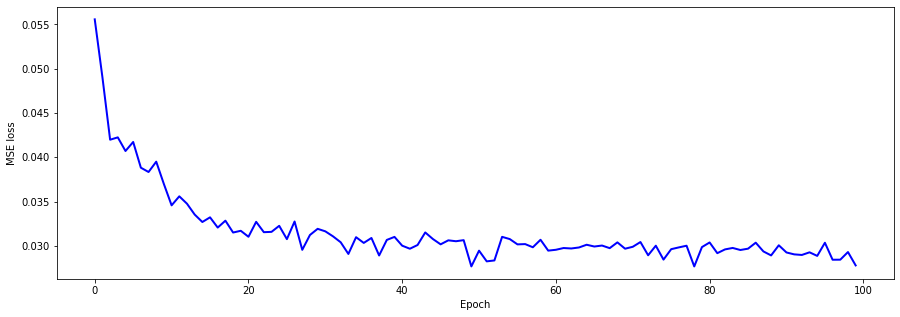

In [10]:
# Plot the training loss
plt.figure(figsize=(15,5))
plt.plot(epoch_losses, lw=2, color='blue')
plt.ylabel('MSE loss')
plt.xlabel('Epoch')

In [11]:
# Encode the images from the test set

# Tensor for storing the latent variables from the encoder 
testdata_latent = torch.zeros(size=(len(mnist_test_loader), BATCH_SIZE, 10))

# Array to store the original mnist test images
testdata_input = np.zeros((len(mnist_test_loader), BATCH_SIZE, 1, 28, 28))

# Encode the images of the test set using the encoder trained on the train set
for i,test_data in enumerate(mnist_test_loader):
    data, label = test_data[0].to(device), test_data[1].to(device)
    img = data.view(data.size(0), -1)
    latent = model.encoder(img)
    testdata_latent[i] = latent
    testdata_input[i] = data.detach().cpu().numpy()

In [12]:
# Instantiate the Kernel PCA object
from sklearn.decomposition import PCA, KernelPCA
kpca = KernelPCA(n_components=10, kernel='rbf', fit_inverse_transform=True)

# Reshape the test set into an array with 2 dimensions
testdata_input_pca = testdata_input.reshape(testdata_input.shape[0]*testdata_input.shape[1], -1)

# Normalizing the input
testdata_input_pca_mean = testdata_input_pca.mean()
testdata_input_pca_std = testdata_input_pca.std()
testdata_input_pca_normalized = (testdata_input_pca - testdata_input_pca_mean)/testdata_input_pca_std

# Apply PCA to find the compressed representation of the test set images
test_data_pca = kpca.fit_transform(testdata_input_pca_normalized)
print('Shape of compressed data after applying PCA: {}'.format(test_data_pca.shape))

# Reconstruct the test set images from the compressed vectors
test_data_pca_reconstructed = kpca.inverse_transform(test_data_pca)
print('Shape of image data after applying the inverse transform of PCA: {}'.format(test_data_pca_reconstructed.shape))

Shape of compressed data after applying PCA: (10000, 10)
Shape of image data after applying the inverse transform of PCA: (10000, 784)


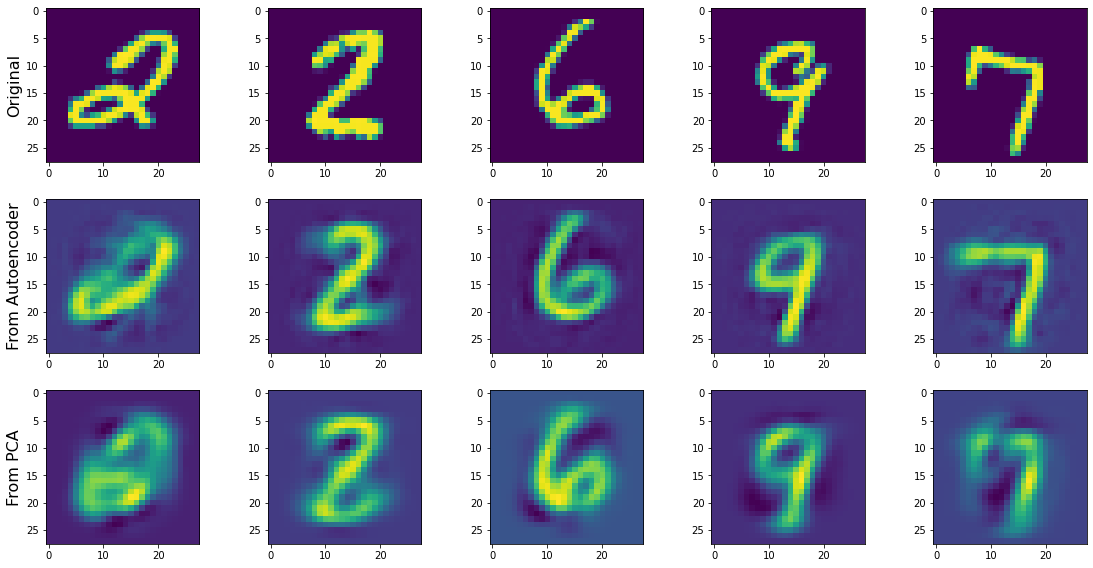

In [13]:
# Set the autoencoder network to evaluation mode
model.eval()

# Select a particular test batch
test_batch_num = 5

# Show 5 images from the selected batch (original, reconstructed from the autoencoder, and from PCA)
fig, axes = plt.subplots(3, 5, figsize=(16,8))

# Select the appropriate latent variables computed by the autoencoder
latents = testdata_latent[test_batch_num][0:5]

# Plot the images
for i, latent in enumerate(latents):

    # Set row titles
    if i==0:
        axes[0, i].set_ylabel('Original', fontsize=16)
        axes[1, i].set_ylabel('From Autoencoder', fontsize=16)
        axes[2, i].set_ylabel('From PCA', fontsize=16)

    # Display original image
    #axes[0, i].axis('off')
    axes[0, i].imshow(testdata_input[test_batch_num][i].reshape(28,28))

    # Display decoded image from Autoencoder
    img = model.decoder(latent.to(device))
    #axes[1, i].axis('off')
    axes[1, i].imshow(img.cpu().detach().numpy().reshape(28,28))

    # Display decoded image from PCA
    #axes[2, i].axis('off')
    pca_img = test_data_pca_reconstructed[test_batch_num*BATCH_SIZE + i].reshape(28,28)
    axes[2, i].imshow(pca_img)

fig.tight_layout()